In [1]:
import pandas as pd
import numpy as np
import pathlib
import math
import tqdm
from BlockSync_current import *

In [22]:
# I now have a ground-truth csv to import:
eye_data = pd.read_csv(pathlib.Path(r'Z:\Nimrod\3D_calibration\eye_ellipse_map_radius_08mm_distance_14mm\ellipse_angle_mapping_correct_r08mm_dist14mm.csv'))
df = eye_data.copy()
df = df.rename(columns={'axs_1':'major_axis', 'axs_2':'minor_axis'})
df['ratio'] = df.major_axis / df.minor_axis

# set the 'roundest ellipse' centerpoint (for the 640x480 frane withe centralized eye)

aEC = 320 
bEC = 240 
# find f/z0 parameter by least squares:

top = 0.0
bot = 0.0
top_list = []
bot_list = []
for row in tqdm(range(len(df))):
    hw = df.iloc[row]['ratio']
    aPC = df.iloc[row]['center_x']
    bPC = df.iloc[row]['center_y']
    if hw == hw:
        top += math.sqrt(1 - hw**2) * math.sqrt((aPC-aEC)**2 + (bPC-bEC)**2)
        top_list.append(math.sqrt(1 - hw**2) * math.sqrt((aPC-aEC)**2 + (bPC-bEC)**2))
        bot += (1 - hw**2)
        bot_list.append(1 - hw**2)
f_z = top / bot
#f_z = f_z_gt
for row in tqdm(range(len(df))):
    computed_r = 2*np.max([df.loc[row,'major_axis'],df.loc[row,'minor_axis']]) / f_z
    df.loc[row, 'r'] = computed_r

for row in tqdm(range(len(df))):        
    comp_t = np.arcsin( (df.loc[row, 'center_x'] - aEC) / f_z)
    comp_p = np.arcsin( (df.loc[row, 'center_y'] - bEC) / (np.cos(comp_t)*f_z) )
    
    df.loc[row, 'theta'] = comp_t*180/np.pi
    df.loc[row, 'phi'] = comp_p*180/np.pi
    

  0%|          | 0/15367 [00:00<?, ?it/s]<ipython-input-22-eefb0c7437d4>:34: RuntimeWarning: invalid value encountered in arcsin
  comp_p = np.arcsin( (df.loc[row, 'center_y'] - bEC) / (np.cos(comp_t)*f_z) )
100%|██████████| 15367/15367 [00:06<00:00, 2453.29it/s]


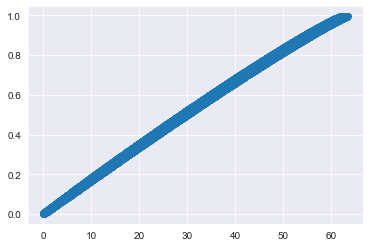

In [23]:
plt.scatter(top_list,bot_list)

Text(0, 0.5, 'computed theta')

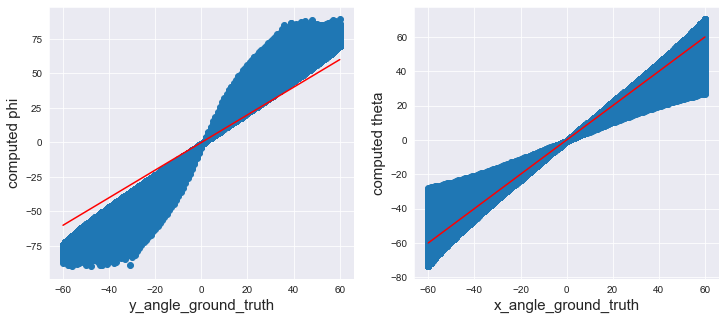

In [40]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

axs[0].scatter(df.y_angle, df.phi)
axs[0].plot([-60,60],[-60,60],c='red')
axs[0].set_xlabel('y_angle_ground_truth',fontsize=15)
axs[0].set_ylabel('computed phi',fontsize=15)
axs[1].plot([-60,60],[-60,60],c='red')
axs[1].scatter(df.x_angle,df.theta)
axs[1].set_xlabel('x_angle_ground_truth',fontsize=15)
axs[1].set_ylabel('computed theta',fontsize=15)

#plt.plot(df.y_angle)
#plt.xlim(0,4000)

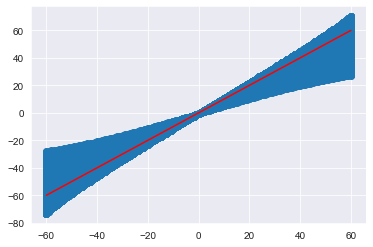

In [32]:
plt.scatter(df.x_angle, df.theta)
plt.plot([-60,60],[-60,60],c='red')

#plt.xlim(0,4000)

(6000.0, 1000.0)

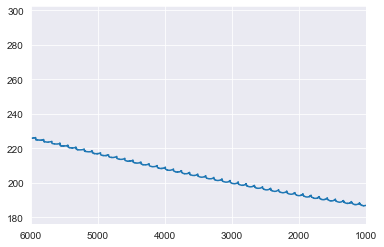

In [19]:
df.center_y.plot()
plt.xlim(12000/2,1200/2+400)

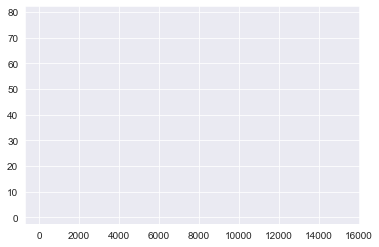

In [60]:
import numpy as np
import pandas as pd

# Assume df is your DataFrame with the required columns
# df = pd.read_csv('your_data.csv')

# Constants
a_EC = ...  # Replace with the actual value
b_EC = ...  # Replace with the actual value

# Step 1: Compute s_i_squared = 1 - (ell / L)^2
df['s_i_squared'] = 1 - (df['ell'] / df['L']) ** 2

# Handle numerical errors by clipping negative values to zero
df['s_i_squared'] = df['s_i_squared'].clip(lower=0)

# Step 2: Compute s_i = sqrt(s_i_squared)
df['s_i'] = np.sqrt(df['s_i_squared'])

# Step 3: Compute d_i = sqrt((a_PC - a_EC)^2 + (b_PC - b_EC)^2)
df['d_i'] = np.sqrt((df['a_PC'] - a_EC) ** 2 + (df['b_PC'] - b_EC) ** 2)

# Step 4: Compute numerator = sum(s_i * d_i)
numerator = (df['s_i'] * df['d_i']).sum()

# Step 5: Compute denominator = sum(s_i_squared)
denominator = df['s_i_squared'].sum()

# Step 6: Compute f_over_z0 = numerator / denominator
f_over_z0 = numerator / denominator

# Step 7: Compute r = L / (f_over_z0)
# If L is a constant, replace df['L'].mean() with the constant value
L = df['L'].mean()
r = L / f_over_z0

# Step 8: Compute theta = arcsin((a_PC - a_EC) / (f_over_z0))
df['theta'] = np.arcsin(np.clip((df['a_PC'] - a_EC) / f_over_z0, -1, 1))

# Step 9: Compute cos(theta)
df['cos_theta'] = np.cos(df['theta'])

# Step 10: Compute phi = arcsin((b_PC - b_EC) / (cos(theta) * f_over_z0))
df['phi'] = np.arcsin(np.clip((df['b_PC'] - b_EC) / (df['cos_theta'] * f_over_z0), -1, 1))

# Optional: Drop intermediate columns if not needed
df.drop(['s_i_squared', 's_i', 'd_i', 'cos_theta'], axis=1, inplace=True)

# Now df contains the new columns 'theta' and 'phi'


In [2]:
# Function definitions
def analyzed_block_automated_pipe(block):
    """This function runs all the import steps that I am already confident about for a block
    that has already gone through synchronization and dlc reading"""
    block.handle_eye_videos()
    block.handle_arena_files()
    block.parse_open_ephys_events()
    block.synchronize_arena_timestamps()
    block.create_arena_brightness_df(threshold_value=240,export=True)
    block.synchronize_block(export=True)
    block.create_eye_brightness_df(threshold_value=250)
    block.import_manual_sync_df()
    block.read_dlc_data()

def head_based_gaze_vector_calculation(block, export=False):
    """
    This function changes re_df and le_df so that they'll include the
    phi2 and theta column corresponding with the degrees from median position for the pupil in every frame
    :param block: BlockSync object to claculate for
    :param export: if true will create a .csv file for each eye
    :return:
    """
    df_dict = {
        'R': block.re_df,
        'L': block.le_df
    }
    for key in df_dict.keys():
        # iterate over eyes
        df = df_dict[key].copy()


        # add column with height / width
        s = df.height/df.width
        s[s>1] = 1 / s[s>1]
        df['h_w'] = s

        # Find Eye Center (the "roundest ellipse" condition's centerpoint)
        max_ratio = pd.to_numeric(df.h_w).idxmax()
        df['h_w'][max_ratio]
        aEC = df['center_x'][max_ratio]
        bEC = df['center_y'][max_ratio]
        # for future reference - this point should be an intersection of all minor axes, and not only an average as is the case now)

        # Find f/z0 using LEAST SQUARES
        top = 0.0
        bot = 0.0
        for row in tqdm(range(len(df))):
            hw = df.iloc[row]['h_w']
            aPC = df.iloc[row]['center_x']
            bPC = df.iloc[row]['center_y']
            if hw == hw:
                top += math.sqrt(1 - hw**2) * math.sqrt((aPC-aEC)**2 + (bPC-bEC)**2)
                bot += (1 - hw**2)
        f_z = top / bot
        for row in tqdm(range(len(df))):
            frame = df.iloc[row][f'{key}_eye_frame']
            if frame == frame:
                comp = 2*np.max([df.loc[row,'height'],df.loc[row,'width']]) / f_z
                df.loc[row, 'r'] = comp
            else:
                df.loc[row, 'r'] = np.nan

        for row in tqdm(range(len(df))):
            frame = df.iloc[row][f'{key}_eye_frame']
            if frame == frame:
                comp_t = np.arcsin( (df.loc[row, 'center_x'] - aEC) / f_z)
                comp_p = np.arcsin( (df.loc[row, 'center_y'] - bEC) / (np.cos(comp_t)*f_z) )

                df.loc[row, 'teta'] = comp_t*180/np.pi
                df.loc[row, 'phi2'] = comp_p*180/np.pi
            else:
                df.loc[row, 'teta'] = np.nan
                df.loc[row, 'phi2'] = np.nan

        if key == 'R':
            block.right_df = df
            if export:
                df.to_csv(block.analysis_path / 'right_df.csv')
        elif key == 'L':
            block.left_df = df
            df.to_csv(block.analysis_path / 'left_df.csv')

In [3]:
#block definition
experiments_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = "PV_62"
date = "2023_04_30"
block_n = "033"

block = BlockSync(animal_call=animal,
                  experiment_date=date,block_num=block_n,
                  path_to_animal_folder=str(experiments_path),regev=True)
analyzed_block_automated_pipe(block)

instantiated block number 033 at Path: Z:\Nimrod\experiments\PV_62\2023_04_30\block_033
Found the sample rate for block 033 in the xml file, it is 20000 Hz
handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_04_30\\block_033\\eye_videos\\LE\\230430_pv62_trial1_640x480_60hz_experiment_1_recording_0\\230430_pv62_trial1.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_04_30\\block_033\\eye_videos\\RE\\230430_pv62_trial1_640x480_60hz_experiment_1_recording_0\\230430_pv62_trial1.h264']
The file Z:\Nimrod\experiments\PV_62\2023_04_30\block_033\eye_videos\RE\230430_pv62_trial1_640x480_60hz_experiment_1_recording_0\230430_pv62_trial1.mp4 already exists, no conversion necessary
Validating videos...
The video named 230430_pv62_trial1_LE.mp4 has reported 94118 frames and has 94119 frames, it has dropped -1 frames
The video named 230430_pv62_trial1.mp4 has reported 94122 frames and has 94122 frames, it has dropped 0 frames
handling arena files
Arena v

ValueError: there is some kind of problem because there should be 2 breaks in the arena TTLsand there are 3

In [4]:
#repr(str(block.oe_path.parent))
#print(str(block.oe_path))
oea.Session(str(block.oe_path.parent)).recordnodes[0].recordings[0].events
#glob.glob(os.path.join(str(block.oe_path.parent), 'Record Node *'))
#os.path.join(block.oe_path.parent, 'Record Node *')

,line,sample_number,processor_id,stream_index,state
0,1,6542438,100,0,0
1,1,6542538,100,0,1
2,1,6542778,100,0,0
3,1,6542877,100,0,1
4,1,6543117,100,0,0
...,...,...,...,...,...
563171,1,38500811,100,0,1
563172,1,38501051,100,0,0
563173,1,38501150,100,0,1
563174,1,38501390,100,0,0


In [37]:
head_based_gaze_vector_calculation(block)

100%|█████████▉| 75421/75424 [00:30<00:00, 2485.85it/s]


TypeError: '>=' not supported between instances of 'NoneType' and 'NoneType'

In [32]:
block.re_df.columns


Index(['Arena_TTL', 'R_eye_frame', 'L_values', 'R_values', 'center_x',
       'center_y', 'width', 'height', 'phi', 'ellipse_size', 'ms_axis'],
      dtype='object')

In [5]:
p = pathlib.Path(r"Z:\Nimrod\experiments\PV_24\2021_12_27\block_012\analysis\re_df.csv")
df = pd.read_csv(p)

In [38]:
df = block.re_df

In [39]:
# add column with height / width
s = df.height/df.width
s[s>1] = 1 / s[s>1]
df['h_w'] = s

In [40]:
semimajor = df.width
semiminor = df.height
np.sum(semimajor<semiminor)

4735

In [42]:
# Find Eye Center (the "roundest ellipse" condition's centerpoint)
max_ratio = pd.to_numeric(df.h_w).idxmax()
df['h_w'][max_ratio]
aEC = df['center_x'][max_ratio]
bEC = df['center_y'][max_ratio]
# for future reference - this point should be an intersection of all minor axes, and not only an average as is the case now)

In [43]:
print(max_ratio)
'''
# This cell computes the local f/z0 for each frame, might not be needed (f is focal length for the lens and z0 is the depth of the weak perspective plane of reference)
for row in tqdm.tqdm(range(len(df))):
    frame = df.iloc[row]['R_eye_frame']
    if frame == frame:
        comp = math.sqrt(math.pow(df.iloc[row]['center_x'] - aEC, 2) + math.pow(df.iloc[row]['center_y'] - bEC, 2)) / math.sqrt((1 - math.pow(df.iloc[row]['h_w'], 2)) )
        df.loc[row, 'f_z'] = comp
    else:
        df.loc[row, 'f_z'] = np.nan
'''

57738


"\n# This cell computes the local f/z0 for each frame, might not be needed (f is focal length for the lens and z0 is the depth of the weak perspective plane of reference)\nfor row in tqdm.tqdm(range(len(df))):\n    frame = df.iloc[row]['R_eye_frame']\n    if frame == frame:\n        comp = math.sqrt(math.pow(df.iloc[row]['center_x'] - aEC, 2) + math.pow(df.iloc[row]['center_y'] - bEC, 2)) / math.sqrt((1 - math.pow(df.iloc[row]['h_w'], 2)) )\n        df.loc[row, 'f_z'] = comp\n    else:\n        df.loc[row, 'f_z'] = np.nan\n"

In [45]:
# Find f/z0 using LEAST SQUARES <- This one is the newest 2022_10_03
top = 0.0
bot = 0.0
for row in tqdm(range(len(df))):
    hw = df.iloc[row]['h_w']
    aPC = df.iloc[row]['center_x']
    bPC = df.iloc[row]['center_y']
    if hw == hw:
        top += math.sqrt(1 - hw**2) * math.sqrt((aPC-aEC)**2 + (bPC-bEC)**2)
        bot += (1 - hw**2)
f_z = top / bot
f_z

100%|██████████| 75424/75424 [00:17<00:00, 4225.59it/s]


109.95572415453303

In [ ]:
#f_z = df['f_z'].median() # just take the median, deprecated

#This is kosher:
for row in tqdm(range(len(df))):
    frame = df.iloc[row]['R_eye_frame']
    print(row,flush=True)
    if frame == frame:
        comp = 2*np.max([df.loc[row,'height'], df.loc[row,'width']]) / f_z
        df.loc[row, 'r'] = comp
    else:
        df.loc[row, 'r'] = np.nan

In [11]:
#f_z = df['f_z'].median() #This looks deprecated again
for row in tqdm.tqdm(range(len(df))):
    frame = df.iloc[row]['R_eye_frame']
    if frame == frame:
        comp_t = np.arcsin( (df.loc[row, 'center_x'] - aEC) / f_z)
        comp_p = np.arcsin( (df.loc[row, 'center_y'] - bEC) / (np.cos(comp_t)*f_z) )

        df.loc[row, 'teta'] = comp_t*180/np.pi
        df.loc[row, 'phi2'] = comp_p*180/np.pi
    else:
        df.loc[row, 'teta'] = np.nan
        df.loc[row, 'phi2'] = np.nan

100%|██████████| 106709/106709 [01:11<00:00, 1487.20it/s]


In [12]:
df.to_csv("after_calc.csv")

In [36]:
max_ratio

11856

In [12]:
df.describe()

,Unnamed: 0,Arena_TTL,R_eye_frame,L_values,R_values,center_x,center_y,width,height,phi,ellipse_size,ms_axis,h_w,r,teta,phi2
count,106709.000000,1.067090e+05,106707.000000,106706.000000,106707.000000,89243.000000,89243.000000,89243.000000,89243.000000,89243.000000,89243.000000,1.067090e+05,89243.000000,89243.000000,89243.000000,89243.000000
mean,53354.000000,1.946805e+07,54692.574320,0.000976,0.000802,308.808944,143.011359,26.249921,24.478026,0.161647,2020.080911,9.098662e+05,0.894442,0.751341,15.525827,-14.545834
std,30804.379275,1.050469e+07,31570.527148,0.972381,0.978804,13.039591,15.600163,1.464962,2.324049,0.495205,229.568958,5.252344e+05,0.053620,0.032915,10.858799,13.785034
min,0.000000,1.270728e+06,3.000000,-40.777567,-41.853195,260.637622,107.611652,13.222510,9.587387,-0.785386,413.848239,0.000000e+00,0.508348,0.371133,-24.344492,-49.866842
25%,26677.000000,1.037082e+07,27352.000000,-0.257794,-0.103526,304.107275,132.600460,25.461839,23.105994,-0.332121,1900.066044,4.550045e+05,0.863513,0.732220,11.410465,-23.534047
50%,53354.000000,1.947042e+07,54700.000000,-0.083970,-0.028591,310.838824,140.291198,26.492331,24.253125,0.343810,2024.823944,9.099847e+05,0.898420,0.754750,16.996168,-16.888913
75%,80031.000000,2.856546e+07,82033.500000,0.134838,0.115728,318.614379,153.986085,27.352347,26.290436,0.546143,2127.101893,1.364737e+06,0.928823,0.773862,23.667656,-4.754837
max,106708.000000,3.765945e+07,109365.000000,1.682037,8.344819,343.438959,206.205827,30.162288,30.100291,0.785391,2716.067897,1.819436e+06,0.999620,0.846602,48.574957,43.599338


In [15]:
print(f"max: {df.idxmax().R}")
print(f"min: {df.idxmin().R}")
import cv2
import os

max: 30793
min: 20606


In [16]:


# attempt to view specific frame
maxframe = df.idxmax().R
minframe = df.idxmin().R
cap = cv2.VideoCapture(r"Z:\Nimrod\experiments\PV_24\26_12_2021\block_6\eye_videos\LE\PV24_EE6_640x480_60hz_experiment_1_recording_0\PV24_EE6_LE.mp4")

for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    if i == minframe and ret:
        cv2.imshow("min_r.png", frame)
        cv2.waitKey(5000)
    if i == maxframe and ret:
        cv2.imshow("max_r.png", frame)
        cv2.waitKey(5000)
    if i == max_ratio and ret:
        cv2.imshow("circle",frame)
        cv2.waitKey(5000)
"""

# get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

# check for valid frame number
if maxframe >= 0 & maxframe <= totalFrames:
    # set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES,maxframe)

while True:
    ret, frame = cap.read()
    cv2.imshow("Video", frame)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break
cap.release()"""
cv2.destroyAllWindows()

In [24]:
p = pathlib.Path(r'Z:\Nimrod\experiments\PV_24\27_12_2021\block_12\eye_videos\RE\PV24_EE12_640x480_60hz_experiment_1_recording_0\PV24_EE12.mp4')
cap = cv2.VideoCapture(str(p))
cap.set(1,100)
ret, I = cap.read()
cap.release()
cv2.imshow('frame',I)

In [25]:
cv2.destroyAllWindows()